Assignment 3

Using the Pima Indians Diabetes data, apply KNN and NB modeling to predict whether a patient with similar features is diabetic.

The dataset contains patient information under 7 catagories: 
   1. Number of times pregnant
   2. Plasma glucose concentration a 2 hours in an oral glucose tolerance test
   3. Diastolic blood pressure (mm Hg)
   4. Triceps skin fold thickness (mm)
   5. 2-Hour serum insulin (mu U/ml)
   6. Body mass index (weight in kg/(height in m)^2)
   7. Diabetes pedigree function
   8. Age (years)

And it specifies whether the patient is diabetic or not (1 representing diabetic; 0 non-diabetic)

I would assume age and number of times pregnant do not have any correlation to diabetes.


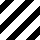
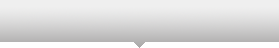
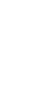
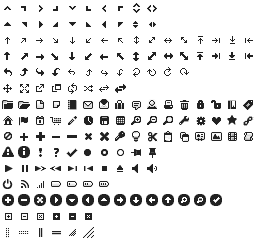
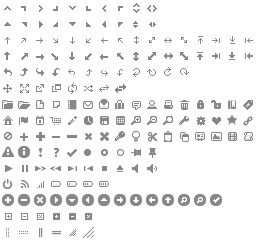
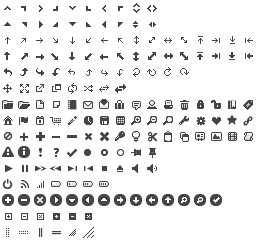
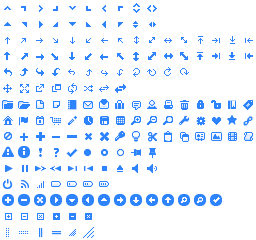
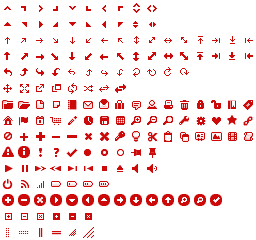
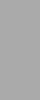
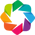
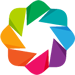
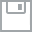
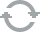
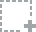
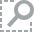
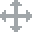
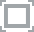
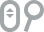

In [2]:
import numpy as np
import pandas as pd
from sklearn.cross_validation import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import cross_val_score
from bokeh.plotting import figure,output_notebook,show,VBox,HBox,gridplot 
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt


%matplotlib inline 
output_notebook()


In [3]:
diabetes= pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data',header=None)
diabetes.columns=['Pregnant','Plasma','Blood Pressure','Skin Fold Thickness','Serum Insulin','BMI','Pedigree','Age','Diabetic']
diabetes.head()


Pregnant  Plasma  Blood Pressure  Skin Fold Thickness  Serum Insulin   BMI  \
0         6     148              72                   35              0  33.6   
1         1      85              66                   29              0  26.6   
2         8     183              64                    0              0  23.3   
3         1      89              66                   23             94  28.1   
4         0     137              40                   35            168  43.1   

   Pedigree  Age  Diabetic  
0     0.627   50         1  
1     0.351   31         0  
2     0.672   32         1  
3     0.167   21         0  
4     2.288   33         1

DATA CLEANING

In [4]:
plots = []
for feat_x in diabetes.columns:
    for feat_y in diabetes.columns:
        
        temp_p = figure(plot_width=200, 
                        plot_height=200, 
                        x_axis_label=feat_x, 
                        y_axis_label=feat_y
                       )
        temp_p.circle(diabetes[feat_x], 
                      diabetes[feat_y], 
                      line_width=1, 
                      alpha=0.4,
                      size=5)
        
        temp_p.xaxis.axis_label_text_font_size = '9pt'
        temp_p.yaxis.axis_label_text_font_size = '9pt'

        plots.append(temp_p)


sqrt = len(plots)**0.5
gplots = np.array(plots).reshape(sqrt,sqrt)


a = gridplot(gplots.tolist())
show(a)

In [5]:
#Looking at the scatterplots, I noticed a large collection of 0 values for Blood Pressure, Skin fold thickness
#and insulin levels

In [6]:
diabetes[diabetes['Blood Pressure']==0].info()
#First anomaly noticed: 35 entries recorded Diastolic Blood Pressure to be 0. Biologically, this is not possible. 
#Hence, I will drop these rows. 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 35 entries, 7 to 706
Data columns (total 9 columns):
Pregnant               35 non-null int64
Plasma                 35 non-null int64
Blood Pressure         35 non-null int64
Skin Fold Thickness    35 non-null int64
Serum Insulin          35 non-null int64
BMI                    35 non-null float64
Pedigree               35 non-null float64
Age                    35 non-null int64
Diabetic               35 non-null int64
dtypes: float64(2), int64(7)
memory usage: 2.7 KB


In [7]:
diabetes1 = diabetes[diabetes['Blood Pressure']!=0] 
diabetes1.head()

Pregnant  Plasma  Blood Pressure  Skin Fold Thickness  Serum Insulin   BMI  \
0         6     148              72                   35              0  33.6   
1         1      85              66                   29              0  26.6   
2         8     183              64                    0              0  23.3   
3         1      89              66                   23             94  28.1   
4         0     137              40                   35            168  43.1   

   Pedigree  Age  Diabetic  
0     0.627   50         1  
1     0.351   31         0  
2     0.672   32         1  
3     0.167   21         0  
4     2.288   33         1

In [8]:
diabetes1[diabetes1['Skin Fold Thickness']==0].info()
#Second anomaly: Skin Fold Thickness measures can never be 0! Hence I the dropped rows with 0 values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 194 entries, 2 to 766
Data columns (total 9 columns):
Pregnant               194 non-null int64
Plasma                 194 non-null int64
Blood Pressure         194 non-null int64
Skin Fold Thickness    194 non-null int64
Serum Insulin          194 non-null int64
BMI                    194 non-null float64
Pedigree               194 non-null float64
Age                    194 non-null int64
Diabetic               194 non-null int64
dtypes: float64(2), int64(7)
memory usage: 15.2 KB


In [9]:
diabetes2 = diabetes1[diabetes1['Skin Fold Thickness']!=0]
diabetes2.head()

Pregnant  Plasma  Blood Pressure  Skin Fold Thickness  Serum Insulin   BMI  \
0         6     148              72                   35              0  33.6   
1         1      85              66                   29              0  26.6   
3         1      89              66                   23             94  28.1   
4         0     137              40                   35            168  43.1   
6         3      78              50                   32             88  31.0   

   Pedigree  Age  Diabetic  
0     0.627   50         1  
1     0.351   31         0  
3     0.167   21         0  
4     2.288   33         1  
6     0.248   26         1

In [10]:
diabetes2[diabetes2['Serum Insulin']==0].info()
#Third Anomaly: There is a large amount of 0 values for Serum Insulin
#with research these cannot be removed as a 0 insulin level is actually an indicator for type 1 diabetes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 145 entries, 0 to 767
Data columns (total 9 columns):
Pregnant               145 non-null int64
Plasma                 145 non-null int64
Blood Pressure         145 non-null int64
Skin Fold Thickness    145 non-null int64
Serum Insulin          145 non-null int64
BMI                    145 non-null float64
Pedigree               145 non-null float64
Age                    145 non-null int64
Diabetic               145 non-null int64
dtypes: float64(2), int64(7)
memory usage: 11.3 KB


In [11]:
#redo-ing previous scatterplots with color indication for diabetics; red for diabetics, blue for non-diabetics
colors = []
for target in diabetes2['Diabetic']:
    if target == 0:
        colors.append('blue')
    elif target == 1:
        colors.append('red')
print colors 

['red', 'blue', 'blue', 'red', 'red', 'red', 'red', 'red', 'red', 'blue', 'red', 'blue', 'red', 'red', 'red', 'blue', 'blue', 'blue', 'red', 'blue', 'blue', 'blue', 'red', 'red', 'red', 'blue', 'blue', 'red', 'red', 'blue', 'red', 'blue', 'blue', 'blue', 'red', 'blue', 'blue', 'red', 'blue', 'blue', 'blue', 'blue', 'red', 'blue', 'blue', 'red', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'red', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'red', 'blue', 'blue', 'blue', 'blue', 'red', 'red', 'red', 'blue', 'red', 'blue', 'blue', 'red', 'blue', 'blue', 'red', 'blue', 'blue', 'red', 'red', 'red', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue', 'red', 'blue', 'red', 'blue', 'blue', 'blue', 'red', 'blue', 'blue', 'blue', 'blue', 'red', 'blue', 'blue', 'red', 'blue', 'blue', 'red', 'red', 'blue', 'blue', 'red', 'red', 'red', 'red', 'red', 'blue', 'blue', 'red

In [12]:
plots = []
for feat_x in diabetes2.columns:
    for feat_y in diabetes2.columns:
        
        temp_p = figure(plot_width=200, 
                        plot_height=200, 
                        x_axis_label=feat_x, 
                        y_axis_label=feat_y
                       )
        temp_p.circle(diabetes2[feat_x], 
                      diabetes2[feat_y], 
                      line_width=1, 
                      color=colors, 
                      alpha=0.4,
                      size=5)
        
        temp_p.xaxis.axis_label_text_font_size = '9pt'
        temp_p.yaxis.axis_label_text_font_size = '9pt'

        plots.append(temp_p)


sqrt = len(plots)**0.5
gplots = np.array(plots).reshape(sqrt,sqrt)


a = gridplot(gplots.tolist())
show(a)


Looking at all the scatterplots, there is no direct correlation between any of the features. However unlike what I assumed in the beginning (age and pregnancy aren't relevant), there are obvious clusterings of reds and blues; indicating a correlation between all features and diabetics. Therefore, I will implement my following models using all the above features.

KNN

In [13]:
#seperating features and labels for KNN modeling 

X=diabetes2.ix[:,:-1].values
y=diabetes2.ix[:,-1:].values


In [14]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.20)

In [15]:
#random choice of using KNN with 11 neighbors to test the result
myknn = KNeighborsClassifier(11).fit(X_train,y_train)
model = KNeighborsClassifier(11)


/Users/chc/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  from IPython.kernel.zmq import kernelapp as app


In [16]:
myknn.predict(X_test)

array([0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0])

In [17]:
myknn.score(X_test, y_test)

0.69444444444444442

In [18]:
target='Diabetic'
features=['Pregnant','Plasma','Blood Pressure','Skin Fold Thickness','Serum Insulin','BMI','Pedigree','Age']
data = diabetes2[features]
label = diabetes2[target]

In [19]:
cross_val_score(model, data, label, cv=5)

array([ 0.75      ,  0.66666667,  0.75      ,  0.80555556,  0.71962617])

In [20]:
np.mean(cross_val_score(model, data, label, cv=5))

0.73836967808930432

In [21]:
n_neighbors = range(1,50,2)
scores = []

for n in n_neighbors:
    model= KNeighborsClassifier(n)
    scores.append(np.mean(cross_val_score(model, data, label, cv=5)))
   
diabetes_df = pd.DataFrame(n_neighbors, columns=['n'])
diabetes_df['CV_scores'] = scores

diabetes_df

n  CV_scores
0    1   0.673468
1    3   0.714278
2    5   0.721720
3    7   0.729162
4    9   0.738387
5   11   0.738370
6   13   0.732797
7   15   0.738387
8   17   0.753236
9   19   0.749515
10  21   0.742125
11  23   0.740256
12  25   0.721668
13  27   0.730980
14  29   0.749550
15  31   0.753271
16  33   0.745864
17  35   0.753288
18  37   0.751402
19  39   0.749585
20  41   0.742143
21  43   0.743994
22  45   0.745812
23  47   0.743977
24  49   0.742073

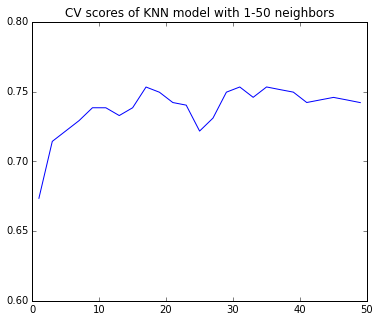

In [22]:
fig = plt.figure(figsize=(6,5))
plt.title('CV scores of KNN model with 1-50 neighbors')
plt.ylim(0.6,0.8)
_=plt.plot(diabetes_df.n, diabetes_df.CV_scores)

Naive Bayes

In [23]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

/Users/chc/anaconda/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [24]:
preds = nb.predict(X_test)
preds

array([0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0])

In [25]:
from sklearn import metrics
print metrics.accuracy_score(y_test, preds)
print metrics.confusion_matrix(y_test, preds)

0.62037037037
[[48 20]
 [21 19]]


In [26]:
model = nb
cross_val_score(model, data, label, cv=5)

array([ 0.66666667,  0.64814815,  0.73148148,  0.68518519,  0.53271028])

In [27]:
np.mean(cross_val_score(model, data, label, cv=5))

0.65283835237106269

Conclusion

Based on the cross validation results, KNN appears to be more accurate than Naive Bayes for classifying diabetics. 